# Hackathon Scouting América



### 0. Imports & get data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from statsbombpy import sb
from mplsoccer.pitch import VerticalPitch
from matplotlib.colors import LinearSegmentedColormap
import os
from pathlib import Path
from dotenv import load_dotenv
# ensure it loads from repo root

In [7]:
load_dotenv(dotenv_path=Path(".").resolve().parent / ".env")

email = os.getenv("SB_USERNAME")
password = os.getenv("SB_PASSWORD")

In [8]:
sb.competitions(creds={"user": email, "passwd": password})

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,73,317,Mexico,Liga MX,male,False,False,2024/2025,2025-08-30T16:14:20.970616,2025-08-30T16:14:20.970616,2025-08-30T16:14:20.970616,2025-08-30T16:14:20.970616
1,73,281,Mexico,Liga MX,male,False,False,2023/2024,2024-12-20T23:40:31.103974,2024-12-20T23:40:31.103974,2024-12-20T23:40:31.103974,2024-12-20T23:40:31.103974
2,73,235,Mexico,Liga MX,male,False,False,2022/2023,2024-09-28T11:05:11.667984,2024-09-28T11:05:11.667984,2024-09-28T11:05:11.667984,2024-09-28T11:05:11.667984
3,73,108,Mexico,Liga MX,male,False,False,2021/2022,2024-12-10T08:59:57.612449,2024-12-10T08:59:57.612449,2024-12-10T08:59:57.612449,2024-12-10T08:59:57.612449


In [9]:
# Fetch matches
get_data = False
if get_data: 
    matches_2122 = sb.matches(competition_id=73, season_id=108, creds={"user": email, "passwd": password})
    matches_2223 = sb.matches(competition_id=73, season_id=235, creds={"user": email, "passwd": password})
    matches_2324 = sb.matches(competition_id=73, season_id=281, creds={"user": email, "passwd": password})
    matches_2425 = sb.matches(competition_id=73, season_id=317, creds={"user": email, "passwd": password})
    matches_2122.to_csv('data/matches_2122.csv')
    matches_2223.to_csv('data/matches_2223.csv')
    matches_2324.to_csv('data/matches_2324.csv')
    matches_2425.to_csv('data/matches_2425.csv')


In [10]:
matches_2122 = pd.read_csv('data/matches_2122.csv')
matches_2223 = pd.read_csv('data/matches_2223.csv')
matches_2324 = pd.read_csv('data/matches_2324.csv')
matches_2425 = pd.read_csv('data/matches_2425.csv')
matches_all = pd.concat([matches_2122, matches_2223, matches_2324, matches_2425], ignore_index=True)

In [11]:
from statsbombpy import sb
import pandas as pd

def build_unique_players_simple(matches_all: pd.DataFrame, email: str, password: str) -> pd.DataFrame:
    """
    Simple dedupe by player_id across all matches:
    - Iterates over home_team and away_team for each match_id
    - Grabs the lineup DF for that team
    - Stores the first non-null value seen for each player field
    - Keeps a set of teams and jersey numbers (collapsed at the end)
    """
    assert {"match_id","home_team","away_team"}.issubset(matches_all.columns)

    creds = {"user": email, "passwd": password}
    players = {}  # player_id -> dict of fields

    def first_nonnull(target_dict, key, new_val):
        if key not in target_dict or pd.isna(target_dict[key]):
            target_dict[key] = new_val

    for _, row in matches_all[["match_id","home_team","away_team"]].dropna().iterrows():
        mid = int(row["match_id"])
        home = str(row["home_team"])
        away = str(row["away_team"])
        print("Getting match "+str(mid))

        try:
            lineups = sb.lineups(match_id=mid, creds=creds)  # {team_name: df}
        except Exception as e:
            print(f"[warn] lineups failed for match_id={mid}: {e}")
            continue

        for team in (home, away):
            df = lineups.get(team)
            if df is None:
                # Fallback: if the key doesn't match exactly, process all teams
                for _, df_any in lineups.items():
                    for _, r in df_any.iterrows():
                        pid = int(r.get("player_id"))
                        pl = players.setdefault(pid, {
                            "player_id": pid,
                            "player_name": pd.NA,
                            "player_nickname": pd.NA,
                            "birth_date": pd.NA,
                            "player_gender": pd.NA,
                            "player_height": pd.NA,
                            "player_weight": pd.NA,
                            "country": pd.NA,
                            "teams_seen": set(),
                            "jersey_numbers": set()
                        })
                        first_nonnull(pl, "player_name", r.get("player_name"))
                        first_nonnull(pl, "player_nickname", r.get("player_nickname"))
                        first_nonnull(pl, "birth_date", r.get("birth_date"))
                        first_nonnull(pl, "player_gender", r.get("player_gender"))
                        first_nonnull(pl, "player_height", r.get("player_height"))
                        first_nonnull(pl, "player_weight", r.get("player_weight"))

                        country_val = r.get("country")
                        if isinstance(country_val, dict):
                            country_val = country_val.get("name") or country_val.get("country_name") or str(country_val)
                        first_nonnull(pl, "country", country_val)

                        # jersey numbers may be mixed
                        jn = pd.to_numeric(r.get("jersey_number"), errors="coerce")
                        if pd.notna(jn):
                            pl["jersey_numbers"].add(int(jn))

                        # No reliable team name here since we’re in fallback; skip teams_seen
                continue

            # Normal path: exact team match
            for _, r in df.iterrows():
                pid = int(r.get("player_id"))
                pl = players.setdefault(pid, {
                    "player_id": pid,
                    "player_name": pd.NA,
                    "player_nickname": pd.NA,
                    "birth_date": pd.NA,
                    "player_gender": pd.NA,
                    "player_height": pd.NA,
                    "player_weight": pd.NA,
                    "country": pd.NA,
                    "teams_seen": set(),
                    "jersey_numbers": set()
                })
                first_nonnull(pl, "player_name", r.get("player_name"))
                first_nonnull(pl, "player_nickname", r.get("player_nickname"))
                first_nonnull(pl, "birth_date", r.get("birth_date"))
                first_nonnull(pl, "player_gender", r.get("player_gender"))
                first_nonnull(pl, "player_height", r.get("player_height"))
                first_nonnull(pl, "player_weight", r.get("player_weight"))

                country_val = r.get("country")
                if isinstance(country_val, dict):
                    country_val = country_val.get("name") or country_val.get("country_name") or str(country_val)
                first_nonnull(pl, "country", country_val)

                jn = pd.to_numeric(r.get("jersey_number"), errors="coerce")
                if pd.notna(jn):
                    pl["jersey_numbers"].add(int(jn))

                pl["teams_seen"].add(team)

    if not players:
        return pd.DataFrame(columns=[
            "player_id","player_name","player_nickname","birth_date","player_gender",
            "player_height","player_weight","country","teams_seen","jersey_numbers"
        ])

    # Collapse sets and build the frame
    records = []
    for pl in players.values():
        records.append({
            "player_id": pl["player_id"],
            "player_name": pl["player_name"],
            "player_nickname": pl["player_nickname"],
            "birth_date": pl["birth_date"],
            "player_gender": pl["player_gender"],
            "player_height": pl["player_height"],
            "player_weight": pl["player_weight"],
            "country": pl["country"],
            "teams_seen": "|".join(sorted(pl["teams_seen"])) if isinstance(pl["teams_seen"], set) else pl["teams_seen"],
            "jersey_numbers": "|".join(map(str, sorted(pl["jersey_numbers"]))) if isinstance(pl["jersey_numbers"], set) else pl["jersey_numbers"],
        })

    df_out = pd.DataFrame.from_records(records).sort_values(["player_name","player_id"], na_position="last").reset_index(drop=True)
    return df_out

In [13]:
get_players = False
if get_players:
    df_players = build_unique_players_simple(matches_all=matches_all, email=email, password=password)
    df_players.head()
    df_players.to_parquet('./artifacts/players_unique.parquet', index=False)
else:
    df_players = pd.read_parquet('./artifacts/players_unique.parquet')

In [14]:
get_data = False
if get_data:
    events_2122 = sb.competition_events(
        country="Mexico",
        division= "Liga MX",
        season="2021/2022",
        gender="male",
        creds={"user": email, "passwd": password}
    )
    events_2223 = sb.competition_events(
        country="Mexico",
        division= "Liga MX",
        season="2022/2023",
        gender="male",
        creds={"user": email, "passwd": password}
    )
    events_2324 = sb.competition_events(
        country="Mexico",
        division= "Liga MX",
        season="2023/2024",
        gender="male",
        creds={"user": email, "passwd": password}
    )
    events_2425 = sb.competition_events(
        country="Mexico",
        division= "Liga MX",
        season="2024/2025",
        gender="male",
        creds={"user": email, "passwd": password}
    )
    events_2122.to_csv('data/events_2122.csv')
    events_2223.to_csv('data/events_2223.csv')
    events_2324.to_csv('data/events_2324.csv')
    events_2425.to_csv('data/events_2425.csv')

In [15]:
events_2122 = pd.read_csv('data/events_2122.csv')
events_2223 = pd.read_csv('data/events_2223.csv')
events_2324 = pd.read_csv('data/events_2324.csv')
events_2425 = pd.read_csv('data/events_2425.csv')

/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_4333/1999902261.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,47,48,52,60,61,62,64,65,66,67,68,69,70,71,72,74,75,76,77,79,82,84,85,86,87,88,89,95,102,103,104,105,106,107,108,112,113,114,115,116,117,118,121,122,124,125,126,128,130,135) have mixed types. Specify dtype option on import or set low_memory=False.
  events_2122 = pd.read_csv('data/events_2122.csv')
/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_4333/1999902261.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,46,47,51,59,60,61,63,64,65,66,67,68,69,70,71,73,74,75,76,78,81,83,84,85,86,87,88,94,101,102,103,104,105,106,107,111,112,113,114,115,116,117,120,121,123,124,125,127,129,134) have mixed types. Specify dtype option on import or set low_memory=False.
  events_

In [16]:
# Add a "season" column to each events df
events_2122['season'] = "2021/2022"
events_2223['season'] = "2022/2023"
events_2324['season'] = "2023/2024"
events_2425['season'] = "2024/2025"

# Concatenate all events into a single df
events_all = pd.concat([events_2122, events_2223, events_2324, events_2425], ignore_index=True)


### 1. Preproc

In [17]:
get_data = True
if get_data:
    data_all = pd.merge(events_all, matches_all, 'left', on = ['match_id', 'season'])
    data_all.to_csv('data/data_all.csv')
else:
    data_all = pd.read_csv('data/data_all.csv')

In [18]:
data_all.head()

,Unnamed: 0_x,50_50,bad_behaviour_card,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-11-13T21:54:07.529948,16,Apertura,Estadio Hidalgo,Fernando Guerrero Ramírez,Paulo César Pezzolano Suárez,Andrés Luciano Lillini,1.1.0,2,2
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-11-13T21:54:07.529948,16,Apertura,Estadio Hidalgo,Fernando Guerrero Ramírez,Paulo César Pezzolano Suárez,Andrés Luciano Lillini,1.1.0,2,2
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-08-08T17:16:35.265000,1,Apertura,Estadio Azteca,Diego Montaño Robles,Juan Máximo Reynoso Guzmán,Beñat San José Gil,1.1.0,2,2
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-08-08T17:16:35.265000,1,Apertura,Estadio Azteca,Diego Montaño Robles,Juan Máximo Reynoso Guzmán,Beñat San José Gil,1.1.0,2,2
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-11-25T23:21:14.238383,15,Apertura,Estadio Azteca,Fernando Guerrero Ramírez,Santiago Hernán Solari Poggio,Miguel Ernesto Herrera Aguirre,1.1.0,2,2


In [27]:
from pathlib import Path
import pandas as pd
import numpy as np
import ast

# === CONFIG ===
OUT_DIR = Path("./artifacts/heatmap_points")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# === 1) Minimal slice: only what we need ===
need_cols = ["location", "player_id"]
missing = [c for c in need_cols if c not in data_all.columns]
if missing:
    raise ValueError(f"data_all is missing columns: {missing}")

df = data_all[need_cols].copy()

# === 2) Parse location (either NaN or string '[x, y]') ===
def parse_loc(v):
    if pd.isna(v):
        return np.nan, np.nan
    if isinstance(v, (list, tuple)) and len(v) >= 2:
        # Just in case some rows are already lists
        try:
            return float(v[0]), float(v[1])
        except Exception:
            return np.nan, np.nan
    if isinstance(v, str):
        s = v.strip()
        if not s or s[0] != "[":
            return np.nan, np.nan
        try:
            x, y = ast.literal_eval(s)
            return float(x), float(y)
        except Exception:
            return np.nan, np.nan
    return np.nan, np.nan

xy = df["location"].apply(parse_loc)
df["x"] = [t[0] for t in xy]
df["y"] = [t[1] for t in xy]
df = df.dropna(subset=["x", "y"]).copy()

# Ensure numeric player_id
df["player_id"] = pd.to_numeric(df["player_id"], errors="coerce")
df = df.dropna(subset=["player_id"])
df["player_id"] = df["player_id"].astype(int)

# === 3) (Optional) restrict to players in df_players ===
if "df_players" in locals() and "player_id" in df_players.columns:
    pid_pool = set(pd.to_numeric(df_players["player_id"], errors="coerce").dropna().astype(int))
    if pid_pool:
        df = df[df["player_id"].isin(pid_pool)].copy()

# Keep only the three columns we need for heatmaps
df = df[["player_id", "x", "y"]]

# === 4) Save one parquet per player_id ===
rows_written = 0
for pid, g in df.groupby("player_id"):
    out_path = OUT_DIR / f"points_{int(pid)}.parquet"
    g.reset_index(drop=True).to_parquet(out_path, index=False)
    rows_written += 1

print(f"Done. Players exported: {rows_written}")
print(f"Output dir: {OUT_DIR.resolve()}")
print("Example file:", (OUT_DIR / "points_<player_id>.parquet"))


Done. Players exported: 1048
Output dir: /Users/sdulongsalazar/Desktop/hackathon-america/artifacts/heatmap_points
Example file: artifacts/heatmap_points/points_<player_id>.parquet


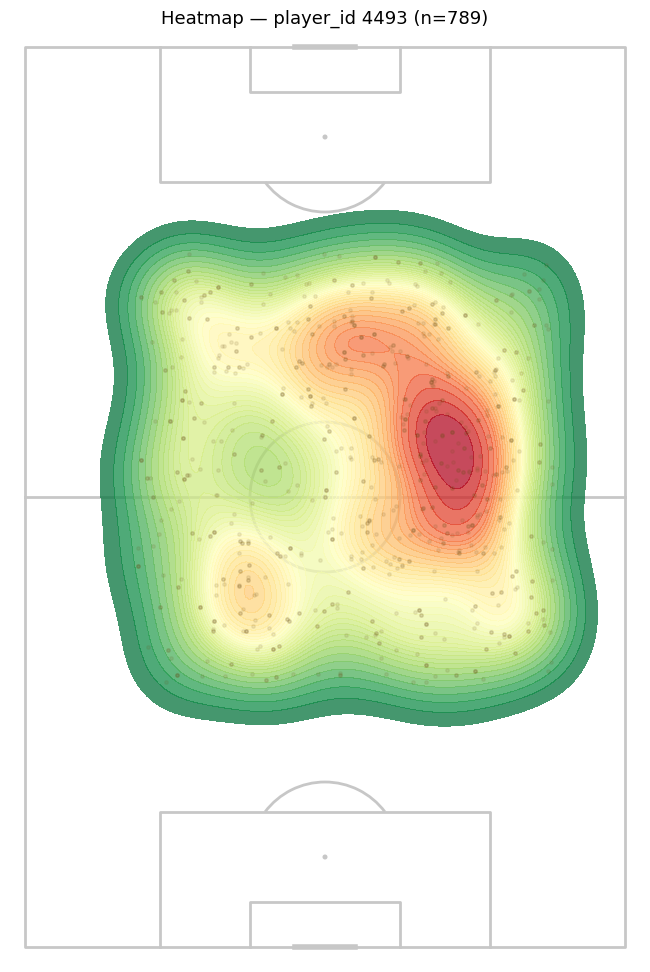

In [40]:
from mplsoccer.pitch import VerticalPitch
import matplotlib.pyplot as plt
import numpy as np

pid = int(df["player_id"].iloc[0])
d = df[df["player_id"] == pid].copy()

# If your coords are 0..100, scale to 120x80
if (d["x"].max() <= 101) and (d["y"].max() <= 101):
    d["x"] *= 1.2
    d["y"] *= 0.8

# --- central-only mask via quantiles (tweak q to be stricter/looser)
q_low, q_high = 0.1, 0.90
x_lo, x_hi = d["x"].quantile(q_low), d["x"].quantile(q_high)
y_lo, y_hi = d["y"].quantile(q_low), d["y"].quantile(q_high)
d_mid = d[(d["x"].between(x_lo, x_hi)) & (d["y"].between(y_lo, y_hi))].copy()

pitch = VerticalPitch(pitch_type="statsbomb", pitch_color="white", line_color="#c7c7c7",
                      pad_bottom=2, pad_top=2, pad_left=2, pad_right=2)
fig, ax = pitch.draw(figsize=(6.6, 10), tight_layout=True)

pitch.kdeplot(
    d_mid["x"], d_mid["y"],
    ax=ax, fill=True, levels=40, thresh=0.03, cmap="RdYlGn_r", alpha=0.75
)
pitch.scatter(d_mid["x"], d_mid["y"], s=6, alpha=0.1, color="#6b4e16", ax=ax, zorder=3)

ax.set_title(f"Heatmap — player_id {pid} (n={len(d_mid)})", fontsize=13)
plt.show()



In [32]:
df_players[df_players['player_id']==4493]

,player_id,player_name,player_nickname,birth_date,player_gender,player_height,player_weight,country,teams_seen,jersey_numbers
211,4493,Cristian Damián Battocchio,Cristian Battocchio,1992-02-10,male,169.0,64.0,Italy,Pumas UNAM,22


In [20]:
data_all.location

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
               ...     
4445125     [4.1, 41.9]
4445126     [2.7, 34.5]
4445127    [11.1, 34.0]
4445128     [4.6, 44.2]
4445129     [1.4, 36.0]
Name: location, Length: 4445130, dtype: object

In [ ]:
from typing import Optional, Tuple, List, Dict

# =========================================================
# 0) Utilidades de coordenadas (StatsBomb-like 120x80)
# =========================================================
def _extract_xyz(val) -> Tuple[Optional[float], Optional[float], Optional[float]]:
    if isinstance(val, (list, tuple)) and len(val) >= 2:
        x = float(val[0]) if val[0] is not None else None
        y = float(val[1]) if val[1] is not None else None
        z = float(val[2]) if (len(val) >= 3 and val[2] is not None) else None
        return x, y, z
    return None, None, None

def add_xyz_columns(df: pd.DataFrame, src_col: str, prefix: Optional[str] = None) -> pd.DataFrame:
    if src_col not in df.columns:
        return df
    if prefix is None:
        prefix = (src_col
                  .replace("_end_location", "_end")
                  .replace("location", "loc")
                  .replace("__", "_"))
    xs, ys, zs = zip(*df[src_col].apply(_extract_xyz))
    df[f"{prefix}_x"] = xs
    df[f"{prefix}_y"] = ys
    df[f"{prefix}_z"] = zs
    return df

def add_xy_all(data_all: pd.DataFrame, extra_end_cols: Optional[List[str]] = None) -> pd.DataFrame:
    df = data_all.copy()
    location_cols = [
        "location",
        "pass_end_location",
        "shot_end_location",
        "carry_end_location",
        "goalkeeper_end_location",
    ]
    if extra_end_cols:
        location_cols.extend(extra_end_cols)
    for c in location_cols:
        if c in df.columns:
            pref = (c.replace("_end_location", "_end")
                      .replace("location", "loc")
                      .replace("__", "_"))
            add_xyz_columns(df, c, prefix=pref)
    return df


def convert_pitch_units(df_with_xy: pd.DataFrame,
                        in_dims: Tuple[float, float]=(120.0, 80.0),
                        out_dims: Tuple[float, float]=(105.0, 68.0),
                        prefixes: Optional[List[str]]=None) -> pd.DataFrame:
    """
    Convert StatsBomb coordinates (120x80) to meters (default 105x68).
    Scales all '*_x'/'*_y' columns matching given prefixes; if prefixes=None, auto-detects.
    """
    df = df_with_xy.copy()
    in_x, in_y = in_dims
    out_x, out_y = out_dims
    sx = out_x / in_x
    sy = out_y / in_y

    if prefixes is None:
        prefixes = sorted(set(c[:-2] for c in df.columns if c.endswith("_x")))

    for pref in prefixes:
        xcol, ycol = f"{pref}_x", f"{pref}_y"
        if xcol in df.columns:
            df[xcol] = pd.to_numeric(df[xcol], errors="coerce") * sx
        if ycol in df.columns:
            df[ycol] = pd.to_numeric(df[ycol], errors="coerce") * sy
    return df

# =========================================================
# 1) Season normalization & helpers
# =========================================================
def _ensure_season(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ensure a 'season' column exists. If missing/empty, derive from year(match_date).
    Accepts match_date as 'YYYY-MM-DD' or parseable timestamp-like.
    """
    out = df.copy()
    if "season" not in out.columns or out["season"].isna().all():
        if "match_date" in out.columns:
            years = pd.to_datetime(out["match_date"], errors="coerce").dt.year.astype("Int64")
            out["season"] = years.astype(str)
        else:
            out["season"] = "unknown"
    return out

def _safe_bool_series(s: pd.Series, default: bool=False) -> pd.Series:
    """Coerce arbitrary series into a boolean series safely."""
    if s is None:
        return pd.Series([default]*0, dtype=bool)
    if s.dtype == bool:
        return s.fillna(default)
    return s.astype(str).str.lower().isin(["true","t","1","yes","y"]).fillna(default)

# =========================================================
# 2) Minutes played (match-level) heuristic without lineups
# =========================================================
def estimate_minutes_by_match_player(data_all: pd.DataFrame) -> pd.DataFrame:
    """
    Heuristic using events only (no lineups):
      - For each match: duration ~ max(minute + second/60), clipped to [0,130].
      - For each player in that match:
            start_min = min event minute for that player
            end_min   = first event with player_off_permanent==True OR match_duration
            minutes   = max(0, end_min - start_min)
      - If minutes = 0 but player appeared, set to 1.0 to avoid divide-by-zero later.
    Returns: match_id, season, player_id, player, team, minutes_played
    """
    df = _ensure_season(data_all).copy()

    minute = pd.to_numeric(df.get("minute", np.nan), errors="coerce")
    second = pd.to_numeric(df.get("second", 0), errors="coerce").fillna(0)
    tmin = minute.fillna(0) + (second.fillna(0) / 60.0)
    df["_tmin"] = tmin

    match_dur = df.groupby("match_id")["_tmin"].max().clip(lower=0, upper=130).rename("match_duration_min")
    start_min = df.groupby(["match_id","player_id"])["_tmin"].min().rename("start_min")

    off_perm = _safe_bool_series(df.get("player_off_permanent", pd.Series(False, index=df.index)), default=False)
    df["_off_perm"] = off_perm
    off_times = df.loc[df["_off_perm"]].groupby(["match_id","player_id"])["_tmin"].min().rename("off_min")

    mp = (start_min.to_frame()
                 .join(off_times, how="left")
                 .join(match_dur, on="match_id", how="left")
                 .reset_index())

    mp["end_min"] = np.where(mp["off_min"].notna(), mp["off_min"], mp["match_duration_min"])
    mp["minutes_played"] = (mp["end_min"] - mp["start_min"]).clip(lower=0)
    mp.loc[(mp["minutes_played"] == 0) & mp["start_min"].notna(), "minutes_played"] = 1.0

    meta_cols = ["player_id","player","team","season","match_id"]
    meta = (_ensure_season(df)[meta_cols]
            .drop_duplicates(subset=["match_id","player_id"])
            .set_index(["match_id","player_id"]))
    mp = (mp.set_index(["match_id","player_id"])
            .join(meta, how="left")
            .reset_index())

    mp = mp[["match_id","season","player_id","player","team","minutes_played"]].fillna({"player":"", "team":""})
    return mp

# =========================================================
# 3) Season-team-player aggregations (totals)
# =========================================================
def aggregate_player_team_season_counts(data_all: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate by (season, team, player_id, player):
      shots, goals, xg, passes_att, passes_cmp, pass_pct, key_passes, assists, xA,
      dribbles_cmp, duels_won, interceptions, blocks, clearances,
      obv_total, obv_for, obv_against
    """
    df = _ensure_season(data_all).copy()
    for col in ["type", "player", "player_id", "team", "season"]:
        if col not in df.columns:
            df[col] = np.nan

    grp = ["season","team","player_id","player"]

    # flags (0/1) to avoid Series vs DataFrame groupby issues
    df["is_shot"] = (df["type"] == "Shot").astype(int)
    df["is_goal"] = ((df["type"] == "Shot") & (df.get("shot_outcome", pd.Series([None]*len(df))) == "Goal")).astype(int)

    xg_col = "shot_statsbomb_xg"
    df["_xg"] = np.where(df["type"].eq("Shot"), df.get(xg_col, np.nan), np.nan)

    df["is_pass"] = (df["type"] == "Pass").astype(int)
    pass_outcome = df.get("pass_outcome", pd.Series([np.nan]*len(df)))
    df["is_pass_cmp"] = ((df["type"] == "Pass") & (pass_outcome.isna())).astype(int)

    df["is_key_pass"] = (df.get("pass_shot_assist", False).fillna(False) & df["type"].eq("Pass")).astype(int)
    df["is_assist"]   = (df.get("pass_goal_assist", False).fillna(False) & df["type"].eq("Pass")).astype(int)

    dribble_outcome = df.get("dribble_outcome", pd.Series([np.nan]*len(df))).astype(str).str.lower()
    df["is_dribble_cmp"] = ((df["type"] == "Dribble") & (dribble_outcome.str.contains("complete"))).astype(int)

    duel_outcome = df.get("duel_outcome", pd.Series([np.nan]*len(df))).astype(str).str.lower()
    df["is_duel_won"] = ((df["type"] == "Duel") & (duel_outcome.str.contains("won"))).astype(int)

    inter_outcome = df.get("interception_outcome", pd.Series([np.nan]*len(df))).astype(str).str.lower()
    df["is_interception"] = ((df["type"] == "Interception") & (inter_outcome.str.contains("won|success"))).astype(int)

    block_cols = [c for c in df.columns if c.startswith("block_")]
    if block_cols:
        blocks_any = df[block_cols].fillna(False).any(axis=1)
        df["is_block"] = (blocks_any & df["type"].eq("Block")).astype(int)
    else:
        df["is_block"] = 0

    if "type" in df.columns and df["type"].eq("Clearance").any():
        df["is_clearance"] = df["type"].eq("Clearance").astype(int)
    else:
        clr_cols = [c for c in df.columns if c.startswith("clearance_")]
        if clr_cols:
            cl_any = df[clr_cols].fillna(False).any(axis=1)
            df["is_clearance"] = cl_any.astype(int)
        else:
            df["is_clearance"] = 0

    # grouped totals
    shots          = df.groupby(grp)["is_shot"].sum(min_count=1).rename("shots")
    goals          = df.groupby(grp)["is_goal"].sum(min_count=1).rename("goals")
    xg             = df.groupby(grp)["_xg"].sum(min_count=1).rename("xg")

    passes_att     = df.groupby(grp)["is_pass"].sum(min_count=1).rename("passes_att")
    passes_cmp     = df.groupby(grp)["is_pass_cmp"].sum(min_count=1).rename("passes_cmp")
    key_passes     = df.groupby(grp)["is_key_pass"].sum(min_count=1).rename("key_passes")
    assists        = df.groupby(grp)["is_assist"].sum(min_count=1).rename("assists")
    dribbles_cmp   = df.groupby(grp)["is_dribble_cmp"].sum(min_count=1).rename("dribbles_cmp")
    duels_won      = df.groupby(grp)["is_duel_won"].sum(min_count=1).rename("duels_won")
    interceptions  = df.groupby(grp)["is_interception"].sum(min_count=1).rename("interceptions")
    blocks         = df.groupby(grp)["is_block"].sum(min_count=1).rename("blocks")
    clearances     = df.groupby(grp)["is_clearance"].sum(min_count=1).rename("clearances")

    # OBV
    obv_total   = df.get("obv_total_net", pd.Series([np.nan]*len(df)))
    obv_for     = df.get("obv_for_net",   pd.Series([np.nan]*len(df)))
    obv_against = df.get("obv_against_net", pd.Series([np.nan]*len(df)))

    obv_total_g    = df.assign(_obv_total=obv_total).groupby(grp)["_obv_total"].sum(min_count=1).rename("obv_total")
    obv_for_g      = df.assign(_obv_for=obv_for).groupby(grp)["_obv_for"].sum(min_count=1).rename("obv_for")
    obv_against_g  = df.assign(_obv_against=obv_against).groupby(grp)["_obv_against"].sum(min_count=1).rename("obv_against")

    # xA (needs shot_key_pass_id, id, xg_col)
    xA = pd.Series(dtype=float, name="xA")
    if {"shot_key_pass_id","id",xg_col}.issubset(df.columns):
        shots_kp  = df.loc[df["type"].eq("Shot"), ["id","shot_key_pass_id",xg_col,"season"]].dropna(subset=["shot_key_pass_id"])
        passes_kp = df.loc[df["type"].eq("Pass"), ["id","player_id","player","team","season"]]
        xA_join   = shots_kp.merge(passes_kp, left_on=["shot_key_pass_id","season"], right_on=["id","season"], how="left")
        xA        = xA_join.groupby(["season","team","player_id","player"])[xg_col].sum(min_count=1).rename("xA")

    pieces = [shots, goals, xg, passes_att, passes_cmp, key_passes, assists,
              dribbles_cmp, duels_won, interceptions, blocks, clearances,
              obv_total_g, obv_for_g, obv_against_g]
    if not xA.empty:
        pieces.append(xA)

    agg = pd.concat(pieces, axis=1).fillna(0)

    # pass%
    agg["pass_pct"] = np.where(agg["passes_att"] > 0,
                               100.0 * agg["passes_cmp"] / agg["passes_att"],
                               np.nan)

    # nice dtypes for counts
    for c in ["shots","goals","passes_att","passes_cmp","key_passes","assists",
              "dribbles_cmp","duels_won","interceptions","blocks","clearances"]:
        if c in agg.columns:
            agg[c] = agg[c].astype("Int64")

    return agg.reset_index().sort_values(["season","team","player"]).reset_index(drop=True)

# =========================================================
# 4) Minutes & games per season-team-player; per90s
# =========================================================
def player_team_season_minutes_games(data_all: pd.DataFrame) -> pd.DataFrame:
    """
    Returns minutes and games by (season, team, player_id, player):
      minutes = sum of estimated minutes_played
      games   = #matches with minutes_played > 0
    """
    mp = estimate_minutes_by_match_player(data_all)
    grp = ["season","team","player_id","player"]

    minutes = mp.groupby(grp)["minutes_played"].sum(min_count=1).rename("minutes")
    mp["played_flag"] = (mp["minutes_played"] > 0).astype(int)
    games = mp.groupby(grp)["played_flag"].sum(min_count=1).rename("games").astype("Int64")

    out = pd.concat([minutes, games], axis=1).reset_index()
    out[["minutes"]] = out[["minutes"]].fillna(0.0)
    out[["games"]]   = out[["games"]].fillna(0)
    return out

def add_per90(agg_counts: pd.DataFrame, minutes_games: pd.DataFrame,
              per90_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Merge totals with minutes/games and compute per90 for selected columns.
    """
    if per90_cols is None:
        per90_cols = [
            "shots","goals","xg","passes_att","passes_cmp","key_passes","assists","xA",
            "dribbles_cmp","duels_won","interceptions","blocks","clearances",
            "obv_total","obv_for","obv_against"
        ]
    df = agg_counts.merge(minutes_games, on=["season","team","player_id","player"], how="left")
    df["minutes"] = df["minutes"].fillna(0.0)
    denom = df["minutes"].replace(0, np.nan) / 90.0
    for c in per90_cols:
        if c in df.columns:
            df[f"{c}_per90"] = df[c] / denom
    return df

# =========================================================
# 5) Full pipeline
# =========================================================
def build_player_team_season_table(data_all: pd.DataFrame) -> pd.DataFrame:
    """
    Pipeline:
      1) (Optional) add_xy_all(data_all)  # not required for aggregations
      2) Aggregate season-team-player totals
      3) Estimate minutes & games season-team-player
      4) Compute per90s
    Returns one row per (season, team, player_id, player).
    """
    agg = aggregate_player_team_season_counts(data_all)
    mg  = player_team_season_minutes_games(data_all)
    out = add_per90(agg, mg)
    # Friendly column order
    first = ["season","team","player_id","player","games","minutes"]
    others = [c for c in out.columns if c not in first]
    return out[first + others]



### 2. Model

In [ ]:
# ========================= EXPORT PIPELINE (TEAM-AGNOSTIC) =========================
# Drop this in a notebook cell or a .py file and run export_artifacts(...)
# Requires: pandas, numpy, scikit-learn

import json
import pickle
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple, Sequence

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline


In [ ]:

# ------------------------------------------------------------------------------
# A) Recency-weighted per-90 (team-agnostic)
# ------------------------------------------------------------------------------
def _detect_per90_cols(df: pd.DataFrame) -> List[str]:
    return sorted([c for c in df.columns if c.endswith("_per90")])

def _season_sort_key(s):
    try:
        return int(str(s).split("-")[0])
    except:
        return s

def recency_weights_k4() -> List[float]:
    return [0.05, 0.10, 0.25, 0.60]  # oldest -> newest

def _effective_weights(weights: Sequence[float], n: int) -> np.ndarray:
    w = np.array(weights[-n:], dtype=float)
    return w / w.sum() if w.sum() > 0 else np.ones(n)/n

def _minutes_scaler(minutes: pd.Series, floor: float = 450.0, cap: float = 2700.0, power: float = 0.5) -> np.ndarray:
    m = minutes.fillna(0).clip(lower=0, upper=cap).astype(float).values
    z = np.clip(m / floor, 0.0, cap / floor)
    return np.power(z, power)

def build_recency_weighted_per90_team_agnostic(
    seasonal_table: pd.DataFrame,
    keys: List[str] = ["player_id","player"],
    K: int = 4,
    recency_weights: Optional[Sequence[float]] = None,
    use_minutes_scaler: bool = True,
    minutes_col: str = "minutes",
    suffix: str = "_per90_rw"
) -> pd.DataFrame:
    if recency_weights is None:
        recency_weights = recency_weights_k4()
    per90_cols = _detect_per90_cols(seasonal_table)
    if not per90_cols:
        raise ValueError("No *_per90 columns found in seasonal_table.")
    req = set(keys + ["season", minutes_col])
    miss = req - set(seasonal_table.columns)
    if miss:
        raise ValueError(f"seasonal_table missing: {miss}")

    df = seasonal_table.copy()
    df["_season_key"] = df["season"].apply(_season_sort_key)

    out = []
    for gvals, gdf in df.groupby(keys, dropna=False):
        gdf = gdf.sort_values("_season_key").tail(K)
        if not len(gdf):
            continue
        base_w = _effective_weights(recency_weights, len(gdf))
        if use_minutes_scaler:
            msc = _minutes_scaler(gdf[minutes_col])
            w = base_w * msc
            w = w / w.sum() if w.sum() > 0 else base_w
        else:
            w = base_w

        row = dict(zip(keys, gvals if isinstance(gvals, tuple) else (gvals,)))
        for c in per90_cols:
            v = gdf[c].astype(float).values
            mask = ~np.isnan(v)
            if mask.sum() == 0:
                row[c.replace("_per90", suffix)] = np.nan
            else:
                ww = w[mask]; ww = ww/ww.sum() if ww.sum()>0 else np.ones(mask.sum())/mask.sum()
                row[c.replace("_per90", suffix)] = float(np.dot(v[mask], ww))
        row["seasons_used"] = "|".join(map(str, gdf["season"].tolist()))
        row["minutes_sum"] = float(gdf[minutes_col].fillna(0).sum())
        row["games_sum"] = int(gdf["games"].fillna(0).sum()) if "games" in gdf.columns else None
        row["last_season"] = str(gdf["season"].iloc[-1])
        out.append(row)
    return pd.DataFrame(out)


In [ ]:

# ------------------------------------------------------------------------------
# B) Position grouping & top-3 positions (≥ 10 distinct matches) — team-agnostic
# ------------------------------------------------------------------------------
POSITION_GROUP_MAP = {
    # Fullbacks & Wingbacks
    "Right Back": "Right Back", "Right Wing Back": "Right Back",
    "Left Back": "Left Back",   "Left Wing Back": "Left Back",
    # Center Backs
    "Center Back": "Center Back", "Right Center Back": "Center Back", "Left Center Back": "Center Back",
    # DMs
    "Center Defensive Midfield": "Defensive Midfield",
    "Right Defensive Midfield": "Defensive Midfield",
    "Left Defensive Midfield":  "Defensive Midfield",
    # CMs
    "Center Midfield": "Center Midfield",
    "Right Center Midfield": "Center Midfield",
    "Left Center Midfield":  "Center Midfield",
    # AMs
    "Center Attacking Midfield": "Attacking Midfield",
    "Right Attacking Midfield":  "Attacking Midfield",
    "Left Attacking Midfield":   "Attacking Midfield",
    # Wingers / wide mids
    "Right Wing": "Right Wing", "Right Midfield": "Right Wing",
    "Left Wing":  "Left Wing",  "Left Midfield":  "Left Wing",
    # Forwards
    "Center Forward": "Center Forward",
    "Right Center Forward": "Center Forward",
    "Left Center Forward":  "Center Forward",
    # Others
    "Goalkeeper": "Goalkeeper",
    "Substitute": "Substitute",
}
ALLOWED_ORIGINAL = set(PERSON for PERSON in POSITION_GROUP_MAP.keys())

def top_positions_grouped_team_agnostic(
    events: pd.DataFrame,
    keys: List[str] = ["player_id","player"],
    pos_col: str = "position",
    match_col: str = "match_id",
    date_col: str = "match_date",
    min_games: int = 10,
    top_k: int = 3,
    exclude_substitute: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    req = set(keys + [pos_col, match_col])
    missing = req - set(events.columns)
    if missing:
        raise ValueError(f"events missing: {missing}")

    df = events[keys + [pos_col, match_col] + ([date_col] if date_col in events.columns else [])].copy()
    df = df.dropna(subset=[pos_col, match_col])
    df = df[df[pos_col].isin(ALLOWED_ORIGINAL)]
    if df.empty:
        raise ValueError("No rows with allowed positions.")
    df["grouped_pos"] = df[pos_col].map(POSITION_GROUP_MAP)
    if exclude_substitute:
        df = df[df["grouped_pos"] != "Substitute"]

    dedup = df.drop_duplicates(subset=keys + ["grouped_pos", match_col])
    games = (dedup.groupby(keys + ["grouped_pos"], as_index=False)[match_col]
                  .nunique().rename(columns={match_col: "games"}))

    if date_col in df.columns:
        tmp = df.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col], errors="coerce")
        last_date = (tmp.dropna(subset=[date_col])
                       .groupby(keys + ["grouped_pos"], as_index=False)[date_col]
                       .max())
        summary = games.merge(last_date, on=keys + ["grouped_pos"], how="left")
    else:
        summary = games.copy()
        summary[date_col] = pd.NaT

    summary = summary[summary["games"] >= min_games]
    if summary.empty:
        wide_cols = keys + ["primary_pos","primary_games","secondary_pos","secondary_games","third_pos","third_games"]
        return pd.DataFrame(columns=wide_cols), summary

    def topk_rows(g: pd.DataFrame) -> pd.Series:
        g2 = g.sort_values(["games", date_col], ascending=[False, False])
        pos_list  = g2["grouped_pos"].tolist()[:top_k]
        game_list = g2["games"].tolist()[:top_k]
        pos_list  += [None] * (top_k - len(pos_list))
        game_list += [np.nan] * (top_k - len(game_list))
        names = ["primary","secondary","third"][:top_k]
        out = {}
        for i, nm in enumerate(names):
            out[f"{nm}_pos"]   = pos_list[i]
            out[f"{nm}_games"] = game_list[i]
        return pd.Series(out)

    wide = (summary.groupby(keys, as_index=False)
                  .apply(topk_rows)
                  .reset_index()
                  .drop(columns=["level_0"], errors="ignore"))
    wide = wide.reindex(columns=keys + ["primary_pos","primary_games","secondary_pos","secondary_games","third_pos","third_games"])
    long_df = summary.rename(columns={date_col: "last_date"})[keys + ["grouped_pos","games","last_date"]]
    return wide, long_df.reset_index(drop=True)


In [ ]:

# ------------------------------------------------------------------------------
# C) Latest team per player (team-agnostic label) & events_min
# ------------------------------------------------------------------------------
def latest_team_per_player(events: pd.DataFrame) -> pd.DataFrame:
    tmp = events[["player_id","player","team","match_date"]].dropna(subset=["player_id","team"]).copy()
    tmp["match_date"] = pd.to_datetime(tmp["match_date"], errors="coerce")
    tmp = tmp.sort_values("match_date").dropna(subset=["match_date"])
    lt = tmp.groupby(["player_id","player"], as_index=False).last()
    return lt.rename(columns={"team":"latest_team"})[["player_id","player","latest_team"]]

def build_events_min(events: pd.DataFrame) -> pd.DataFrame:
    keep = ["match_id","match_date","team","team_id","player_id","player","type",
            "minute","second","tactics","home_team","away_team","shot_statsbomb_xg"]
    cols = [c for c in keep if c in events.columns]
    return events[cols].copy()


In [29]:

# ------------------------------------------------------------------------------
# D) Clustering within grouped positions (auto-K ≤ 5)
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from typing import Dict, List, Optional
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Map any synonyms/variants to your 10 canonical grouped positions
POSITION_NORMALIZER = {
    # full-backs / wing-backs
    "Right Wing Back": "Right Back",
    "Left Wing Back":  "Left Back",
    "RB": "Right Back",
    "LB": "Left Back",

    # center back synonyms
    "RCB": "Center Back",
    "LCB": "Center Back",
    "CB":  "Center Back",

    # midfield
    "CDM": "Defensive Midfield",
    "DM":  "Defensive Midfield",
    "CM":  "Center Midfield",
    "CAM": "Attacking Midfield",
    "AM":  "Attacking Midfield",

    # wide
    "RW": "Right Wing",
    "LW": "Left Wing",

    # forwards
    "CF": "Center Forward",
    "ST": "Center Forward",
}

CANONICAL_POSITIONS = [
    "Goalkeeper",
    "Right Back", "Center Back", "Left Back",
    "Defensive Midfield",
    "Center Midfield",
    "Attacking Midfield",
    "Right Wing", "Left Wing",
    "Center Forward",
]

def normalize_grouped_position(s: pd.Series) -> pd.Series:
    """Strip whitespace and map variants to your canonical 10 names."""
    s = s.astype(str).str.strip()
    return s.replace(POSITION_NORMALIZER)

from sklearn.decomposition import PCA
from numpy.linalg import norm

# ------------- helpers -------------
def _detect_per90_rw_cols(df: pd.DataFrame) -> List[str]:
    return sorted([c for c in df.columns if c.endswith("_per90_rw")])

def _top_feature_label(centroid: np.ndarray, feature_names: List[str], k_top: int = 3) -> str:
    idx = np.argsort(np.abs(centroid))[::-1][:k_top]
    return ", ".join([("+" if centroid[j] >= 0 else "-") + feature_names[j] for j in idx])

def _nearest_centroid(vec: np.ndarray, cents: np.ndarray) -> int:
    d = norm(cents - vec[None, :], axis=1)
    return int(np.argmin(d))

def _merge_small_clusters(
    X: np.ndarray, labels: np.ndarray, cents: np.ndarray, min_cluster_size: int
) -> np.ndarray:
    """
    Any cluster with size < min_cluster_size gets reassigned to the nearest
    centroid among clusters that already satisfy the minimum (or the largest).
    Recompute until stable or one pass is enough for practical usage.
    """
    lbl = labels.copy()
    changed = True
    while changed:
        changed = False
        # sizes by current labels
        unique, counts = np.unique(lbl, return_counts=True)
        size_map = dict(zip(unique, counts))
        ok_clusters = [c for c, sz in size_map.items() if sz >= min_cluster_size]
        if not ok_clusters:
            # fallback: keep a single biggest cluster as ok
            biggest = int(unique[np.argmax(counts)])
            ok_clusters = [biggest]

        for c in unique:
            if size_map[c] < min_cluster_size:
                # reassign all points of cluster c
                mask = (lbl == c)
                # nearest centroid among ok_clusters
                ok_centroids = cents[ok_clusters]
                # recompute nearest for each point
                for i in np.where(mask)[0]:
                    new_c_rel = _nearest_centroid(X[i], ok_centroids)
                    new_c = ok_clusters[new_c_rel]
                    if new_c != lbl[i]:
                        lbl[i] = new_c
                        changed = True

        # update sizes & stop if no change
    return lbl

def _recompute_centroids(Z: np.ndarray, labels: np.ndarray) -> np.ndarray:
    cents = []
    for k in np.unique(labels):
        cents.append(Z[labels == k].mean(axis=0))
    return np.vstack(cents)

def _kmeans_two_with_min_size(
    Z: np.ndarray,
    min_size: int,
    random_state: int = 7,
    n_init: int = 20,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Force K=2. If one cluster < min_size and n >= 2*min_size, move the closest
    points from the larger cluster to the smaller until the smaller reaches min_size.
    Returns (labels, centroids) in 2-cluster indexing {0,1}.
    """
    n = Z.shape[0]
    km = KMeans(n_clusters=2, random_state=random_state, n_init=n_init)
    labels = km.fit_predict(Z)
    cents = km.cluster_centers_

    # Current sizes
    uniq, counts = np.unique(labels, return_counts=True)
    size_map = dict(zip(uniq, counts))
    if min(size_map.values()) >= min_size:
        return labels, cents

    if n < 2 * min_size:
        print(f"[GK] Warning: n={n} < 2*min_size={2*min_size}. "
              f"Keeping K=2 split (cannot satisfy min_size for both).")
        return labels, cents

    # Identify small/big clusters
    small = min(size_map, key=size_map.get)
    big   = 1 - small
    need  = min_size - size_map[small]
    if need <= 0:
        return labels, cents

    # Distances of all points in the big cluster to the small centroid
    big_idx = np.where(labels == big)[0]
    d = norm(Z[big_idx] - cents[small][None, :], axis=1)
    # Sort candidates by closeness to small centroid
    order = np.argsort(d)

    moved = 0
    for idx in big_idx[order]:
        # Move this point to small
        labels[idx] = small
        moved += 1
        # Check sizes after each move
        uniq, counts = np.unique(labels, return_counts=True)
        size_map = dict(zip(uniq, counts))
        if size_map[small] >= min_size:
            break
        # If big would drop below min_size by continuing, stop (avoid creating a new violation)
        if size_map[big] - 1 < min_size and moved < need:
            break

    # Final centroids after reassignment
    cents = _recompute_centroids(Z, labels)
    # Sanity: still 2 clusters
    if len(np.unique(labels)) < 2:
        print("[GK] Warning: reassignment collapsed to 1 cluster; reverting to initial split.")
        labels = km.labels_
        cents  = km.cluster_centers_

    return labels.astype(int), cents


# ------------- main clustering -------------
def cluster_players_per_grouped_position_team_agnostic_balanced(
    rw_profiles: pd.DataFrame,
    prim_pos: pd.DataFrame,    # keys + ["primary_pos","primary_games"] (grouped names)
    keys: List[str] = ["player_id","player"],
    n_clusters_by_pos: Optional[Dict[str, int]] = None,
    default_k: Optional[Dict[str, int]] = None,
    random_state: int = 7,
    min_group_size_for_kmeans: int = 8,
    min_cluster_size: int = 6,
    min_games_in_pos: int = 5,
    use_pca: bool = True,
    pca_components: int = 8,
    gk_force_two: bool = True,
    gk_min_cluster_size: int = 15,
) -> pd.DataFrame:
    """
    Static-K per grouped position using *_per90_rw features, but:
      - filters players with < min_games_in_pos for that grouped pos,
      - downshifts K until all clusters meet min_cluster_size (or K=1),
      - merges any small clusters into nearest large centroid (safety),
      - standardizes features; optional PCA to stabilize shapes.

    Returns a DataFrame with: keys + [primary_grouped_pos, games_in_pos, pos_cluster_id, pos_cluster_label]
    """
    # default K (if not provided)
    _default_k = {
        "Goalkeeper": 3,
        "Right Back": 4, "Left Back": 4,
        "Center Back": 4,
        "Defensive Midfield": 4,
        "Center Midfield": 4,
        "Attacking Midfield": 4,
        "Right Wing": 4, "Left Wing": 4,
        "Center Forward": 5,
    }
    if n_clusters_by_pos is None and default_k is None:
        n_clusters_by_pos = _default_k
    elif n_clusters_by_pos is None:
        n_clusters_by_pos = default_k

    per90_cols = _detect_per90_rw_cols(rw_profiles)
    if not per90_cols:
        raise ValueError("No *_per90_rw in rw_profiles.")

    # Join primary grouped position + games
    df = rw_profiles.merge(
        prim_pos.rename(columns={"primary_pos": "primary_grouped_pos",
                                 "primary_games": "games_in_pos"}),
        on=keys, how="inner"
    )

    # Filter by min games in that grouped position
    df = df[df["games_in_pos"].fillna(0).astype(int) >= int(min_games_in_pos)].copy()
    if df.empty:
        raise ValueError("No players meet min_games_in_pos for clustering.")

    results = []
    for pos, g in df.groupby("primary_grouped_pos", dropna=False):
        g = g.copy()
        X_raw = g[per90_cols].astype(float).fillna(0.0).values

        if len(g) < max(min_group_size_for_kmeans, 2) or np.nanmax(np.var(X_raw, axis=0)) < 1e-9:
            labels = np.zeros(len(g), dtype=int)
            cents = None
        else:
            scaler = StandardScaler()
            Z = scaler.fit_transform(X_raw)

            if use_pca:
                n_comp = min(pca_components, Z.shape[1], max(2, Z.shape[0]-1))
                pca = PCA(n_components=n_comp, random_state=random_state)
                Z = pca.fit_transform(Z)

            if gk_force_two and pos == "Goalkeeper":
                # ---- GK: FORCE K=2 with per-cluster min size ----
                labels, cents = _kmeans_two_with_min_size(
                    Z, min_size=gk_min_cluster_size, random_state=random_state, n_init=20
                )
            else:
                # ---- non-GK: your balanced static-K with downshift + safety merge ----
                K = int(n_clusters_by_pos.get(pos, 3))
                K = max(1, min(K, len(g)))
                km = None
                labels = None
                while K >= 1:
                    km = KMeans(n_clusters=K, random_state=random_state, n_init=20)
                    labels = km.fit_predict(Z)
                    uniq, counts = np.unique(labels, return_counts=True)
                    if (counts >= min_cluster_size).all() or K == 1:
                        break
                    K -= 1
                cents = km.cluster_centers_ if km is not None else None

                # safety merge small clusters (if any) into nearest big centroid
                if cents is not None:
                    uniq, counts = np.unique(labels, return_counts=True)
                    if (counts < min_cluster_size).any() and len(uniq) > 1:
                        labels = _merge_small_clusters(Z, labels, cents, min_cluster_size)
                        # recompute centroids after merge for labeling
                        cents = _recompute_centroids(Z, labels)

        labels = labels.astype(int)
        # --- labeling (top features) ---
        if cents is None:
            label_texts = ["small-group"] * len(g)
        else:
            def top_text_for_label(kidx: int) -> str:
                centroid_std = cents[kidx]
                if use_pca:
                    centroid_std_full = (centroid_std @ pca.components_)
                else:
                    centroid_std_full = centroid_std
                return _top_feature_label(centroid_std_full, per90_cols, k_top=3)
            label_texts = [top_text_for_label(l) for l in labels]

        sub = g[keys + ["primary_grouped_pos","games_in_pos"]].copy()
        sub["pos_cluster_id"] = labels
        sub["pos_cluster_label"] = [f"{pos} | {t}" for t in label_texts]
        results.append(sub)

    return pd.concat(results, axis=0).reset_index(drop=True)

In [30]:

# ------------------------------------------------------------------------------
# E) Targets/appearances and design matrix; twin models: xG For & xG Against
# ------------------------------------------------------------------------------
def build_match_targets_and_appearances(
    events: pd.DataFrame,
    xg_col: str = "shot_statsbomb_xg"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    req_cols = {"match_id", "team_id", "team", "type", "player_id"}
    missing = req_cols - set(events.columns)
    if missing:
        raise ValueError(f"events missing: {missing}")
    ev = events.copy()
    if xg_col not in ev.columns:
        ev[xg_col] = 0.0
    ev[xg_col] = pd.to_numeric(ev[xg_col], errors="coerce").fillna(0.0)
    shots = ev.loc[ev["type"].eq("Shot"), ["match_id","team_id","team", xg_col]].copy()
    xg_for = (shots.groupby(["match_id","team_id","team"], as_index=False)[xg_col]
                   .sum().rename(columns={xg_col: "xg_for"}))
    xg_match = xg_for.groupby("match_id", as_index=False)["xg_for"].sum().rename(columns={"xg_for":"xg_total_match"})
    targets = xg_for.merge(xg_match, on="match_id", how="left")
    targets["xg_against"] = targets["xg_total_match"] - targets["xg_for"]
    targets = targets.drop(columns=["xg_total_match"])
    # controls
    if {"home_team","away_team"}.issubset(ev.columns):
        ha = ev.groupby("match_id")[["home_team","away_team"]].first().reset_index()
        targets = targets.merge(ha, on="match_id", how="left")
        targets["is_home"] = (targets["team"] == targets["home_team"]).astype(int)
        targets = targets.drop(columns=["home_team","away_team"])
    else:
        targets["is_home"] = 0
    # appearances
    appearances = (ev.dropna(subset=["player_id"])
                    .groupby(["match_id","team_id"])["player_id"]
                    .unique().reset_index()
                    .rename(columns={"player_id":"player_ids"}))
    return targets, appearances


In [31]:

@dataclass
class DesignMatrixBuilder:
    min_app_per_player: int = 5
    role_col: str = "pos_cluster_id"
    def build(self, targets: pd.DataFrame, appearances: pd.DataFrame,
              player_roles: pd.DataFrame, id_cols_roles: List[str] = ["player_id"]
              ) -> Tuple[pd.DataFrame, Dict[str, List[int]], List[str]]:
        df = targets.merge(appearances, on=["match_id","team_id"], how="left")
        df["player_ids"] = df["player_ids"].apply(lambda x: x if isinstance(x, (list, np.ndarray)) else [])
        pr = player_roles[id_cols_roles + [self.role_col]].drop_duplicates("player_id").set_index("player_id")
        counts = df["player_ids"].explode().value_counts()
        kept_players = counts[counts >= self.min_app_per_player].index.astype(int).tolist()
        player_list = sorted(kept_players); player_index = {pid:i for i,pid in enumerate(player_list)}
        role_list = sorted(pr[self.role_col].dropna().astype(int).unique().tolist())
        role_index = {rid:i for i,rid in enumerate(role_list)}

        rows = []
        for _, r in df.iterrows():
            pids = []
            for p in r["player_ids"]:
                try: ip = int(p); pids.append(ip)
                except: continue
            pids = [pid for pid in pids if pid in player_index]
            row_p = np.zeros(len(player_list), dtype=float)
            for pid in pids: row_p[player_index[pid]] = 1.0
            row_r = np.zeros(len(role_list), dtype=float)
            for pid in pids:
                if pid in pr.index:
                    rid = pr.loc[pid, self.role_col]
                    if pd.notna(rid):
                        rid=int(rid)
                        if rid in role_index: row_r[role_index[rid]] += 1.0
            rows.append({"players": row_p, "roles": row_r,
                         "is_home": float(r.get("is_home",0.0)),
                         "xg_for": float(r.get("xg_for",0.0)),
                         "xg_against": float(r.get("xg_against",0.0))})

        # features
        X_parts, colnames = [], []
        if player_list:
            P = np.vstack([rw["players"] for rw in rows]) if rows else np.empty((0,len(player_list)))
            P_cols = [f"P_{pid}" for pid in player_list]
            X_parts.append(pd.DataFrame(P, columns=P_cols)); colnames += P_cols
        if role_list:
            R = np.vstack([rw["roles"] for rw in rows]) if rows else np.empty((0,len(role_list)))
            R_cols = [f"R_{rid}" for rid in role_list]
            X_parts.append(pd.DataFrame(R, columns=R_cols)); colnames += R_cols
        C = pd.DataFrame({"is_home":[rw["is_home"] for rw in rows]})
        X_parts.append(C); colnames.append("is_home")
        X = pd.concat(X_parts, axis=1).astype(float) if X_parts else pd.DataFrame()
        y_for = pd.Series([rw["xg_for"] for rw in rows], name="y_for").astype(float)
        y_against = pd.Series([rw["xg_against"] for rw in rows], name="y_against").astype(float)
        mapping = {"players": player_list, "roles": role_list}
        return X, mapping, colnames, y_for, y_against

def train_two_ridge_models_for_against(X: pd.DataFrame, y_for: pd.Series, y_against: pd.Series) -> Tuple[Pipeline, Pipeline]:
    def fit_one(y):
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge", RidgeCV(alphas=(0.1,0.3,1.0,3.0,10.0), cv=5, fit_intercept=True))
        ])
        pipe.fit(X.values, y.values)
        return pipe
    return fit_one(y_for), fit_one(y_against)


In [32]:

# ------------------------------------------------------------------------------
# F) Latest XI for ANY team (team-agnostic helper)
# ------------------------------------------------------------------------------
def _parse_datetime_safe(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce")

def get_last_starting_xi_ids(events_min: pd.DataFrame, team_name: str) -> Tuple[List[int], int]:
    df = events_min.copy()
    mt = df.loc[df["team"] == team_name, ["match_id","match_date"]].drop_duplicates("match_id")
    if mt.empty:
        raise ValueError(f"No matches found for team='{team_name}'.")
    if mt["match_date"].notna().any():
        mt["match_date"] = _parse_datetime_safe(mt["match_date"])
        latest = mt.sort_values("match_date").iloc[-1]
    else:
        latest = mt.sort_values("match_id").iloc[-1]
    match_id = int(latest["match_id"])

    emt = df[(df["match_id"] == match_id) & (df["team"] == team_name)].copy()
    xi_rows = emt.loc[emt["type"] == "Starting XI"]
    if not xi_rows.empty and "tactics" in xi_rows.columns:
        tac = xi_rows.iloc[0].get("tactics", {})
        lineup = tac.get("lineup", []) if isinstance(tac, dict) else []
        ids = [p.get("player_id") for p in lineup if isinstance(p, dict) and p.get("player_id") is not None]
        if len(ids) >= 10:
            return [int(x) for x in ids[:11]], match_id
    # fallback: earliest 11 appearances
    emt["tmin"] = emt["minute"].fillna(0).astype(float) + emt["second"].fillna(0).astype(float)/60.0
    first_seen = (emt.dropna(subset=["player_id"])
                    .groupby(["player_id","player"], as_index=False)["tmin"]
                    .min().sort_values("tmin").head(11))
    return first_seen["player_id"].astype(int).tolist(), match_id


In [33]:
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
import pickle

# ---------- helpers ----------
def _detect_per90_cols(df: pd.DataFrame) -> List[str]:
    return sorted([c for c in df.columns if c.endswith("_per90")])

def _detect_per90_rw_cols(df: pd.DataFrame) -> List[str]:
    return sorted([c for c in df.columns if c.endswith("_per90_rw")])

def _season_key(s):
    try:
        return int(str(s).split("-")[0])
    except:
        return s

# ---------- A) Team-season style (aggregate) ----------
def build_team_season_style(events_all: pd.DataFrame,
                            stat_cols_team: Optional[List[str]] = None,
                            min_minutes: float = 0.0) -> pd.DataFrame:
    """
    Aggregate team-season style features from events. For v1 we reuse per90-like
    columns you already carry at event level (xg, xA, passes, obv, etc.).
    If you only have player-level season tables, you can aggregate from that instead.
    """
    df = events_all.copy()

    # If you already have a match-level team table, use it here instead of raw events.
    # Fallback: compute a small subset from events (count-based) – adjust to your schema.
    # Here we assume you have 'season', 'team', and columns like obv_* or pass_* at event rows.

    # Example: team-season counts (very light)
    group = ["season", "team"]
    # Define a few robust team-level proxies (tweak/expand to your columns)
    agg_map = {
        "pass_pass_success_probability": "mean",
        "pass_length": "mean",
        "shot_statsbomb_xg": "sum",
        "duel_outcome": "count",            # proxy for intensity
        "counterpress": "sum",
        "obv_total_net": "sum",
    }
    has = [c for c in agg_map if c in df.columns]
    if not has:
        raise ValueError("build_team_season_style: no suitable columns in events_all; adjust agg_map.")
    team_season = (df.groupby(group)[has].agg(agg_map).reset_index())

    # normalize sizes to per-game if you have games per season per team
    if "match_id" in df.columns:
        gpg = (df.drop_duplicates(["season", "team", "match_id"])
                 .groupby(["season","team"]).size().reset_index(name="n_games"))
        team_season = team_season.merge(gpg, on=["season","team"], how="left")
        for col in ["shot_statsbomb_xg", "duel_outcome", "counterpress", "obv_total_net"]:
            if col in team_season.columns:
                team_season[col] = team_season[col] / team_season["n_games"].replace(0, np.nan)

    # PCA to style components (keep 3 by default)
    feat_cols = [c for c in team_season.columns if c not in ["season","team","n_games"]]
    X = team_season[feat_cols].astype(float).fillna(0.0).values
    scaler = StandardScaler().fit(X)
    Xn = scaler.transform(X)
    pca = PCA(n_components=min(3, Xn.shape[1])).fit(Xn)
    Z = pca.transform(Xn)
    for i in range(Z.shape[1]):
        team_season[f"style_pc{i+1}"] = Z[:, i]

    meta = {"scaler_means": scaler.mean_.tolist(),
            "scaler_scales": scaler.scale_.tolist(),
            "pca_components": pca.components_.tolist(),
            "pca_mean": pca.mean_.tolist(),
            "feat_cols": feat_cols}

    # keep only components and keys
    keep = ["season","team"] + [f"style_pc{i+1}" for i in range(Z.shape[1])]
    return team_season[keep], meta

# ---------- B) Team-season lineup role mix ----------
def build_team_season_role_mix(events_all: pd.DataFrame,
                               clusters: pd.DataFrame) -> pd.DataFrame:
    """
    For each team-season, count appearances by pos_cluster_id in Starting XI (or first 11 seen).
    Normalize to proportions.
    """
    df = events_all.copy()
    # find XI per match per team
    xi = df[(df["type"]=="Starting XI") & df["tactics"].notna()][["season","team","match_id","tactics"]].copy()
    rows = []
    for _, r in xi.iterrows():
        lineup = r["tactics"].get("lineup", []) if isinstance(r["tactics"], dict) else []
        pids = [p.get("player_id") for p in lineup if isinstance(p, dict)]
        for pid in pids:
            rows.append({"season": r["season"], "team": r["team"], "match_id": r["match_id"], "player_id": pid})
    xi_long = pd.DataFrame(rows)
    if xi_long.empty:
        # fallback: first 11 seen by minute
        df["tmin"] = df["minute"].fillna(0) + df["second"].fillna(0)/60.0
        tmp = (df.dropna(subset=["player_id"])
                 .sort_values(["season","team","match_id","tmin"])
                 .groupby(["season","team","match_id"])
                 .head(11)[["season","team","match_id","player_id"]])
        xi_long = tmp

    role = clusters.drop_duplicates("player_id")[["player_id","pos_cluster_id"]]
    xi_role = xi_long.merge(role, on="player_id", how="left").dropna(subset=["pos_cluster_id"])
    cnt = (xi_role.groupby(["season","team","pos_cluster_id"])
                  .size().reset_index(name="count"))
    # convert to wide proportions
    total = cnt.groupby(["season","team"])["count"].sum().reset_index(name="total")
    cnt = cnt.merge(total, on=["season","team"], how="left")
    cnt["prop"] = cnt["count"] / cnt["total"].replace(0, np.nan)
    wide = (cnt.pivot(index=["season","team"],
                      columns="pos_cluster_id",
                      values="prop")
               .fillna(0.0).reset_index())
    wide.columns = ["season","team"] + [f"role_mix_{int(c)}" for c in wide.columns[2:]]
    return wide

# ---------- C) Assemble training table ----------
def prepare_network_training(
    seasonal_table: pd.DataFrame,           # player-team-season per90 targets
    rw_profiles: pd.DataFrame,              # player baseline per90_rw
    clusters: pd.DataFrame,                 # for pos + role ids
    team_style: pd.DataFrame,               # style_pc1..k
    team_role_mix: pd.DataFrame,            # role_mix_*
    keys: List[str] = ["player_id","player"]
) -> Tuple[pd.DataFrame, List[str], List[str]]:
    """
    Build training rows: y = season per90; X = [player RW baseline, team style PCs, role mix].
    Returns (train_df, feature_cols, target_cols).
    """
    # targets
    per90_cols = _detect_per90_cols(seasonal_table)
    base = seasonal_table[keys + ["team","season"] + per90_cols].copy()

    # baseline RW
    rw = rw_profiles[keys + _detect_per90_rw_cols(rw_profiles)].copy()

    # roles / positions
    role_lookup = clusters.drop_duplicates("player_id")[["player_id","pos_cluster_id","primary_grouped_pos"]]

    # join
    df = (base
          .merge(rw, on=keys, how="left")
          .merge(role_lookup, on="player_id", how="left")
          .merge(team_style, on=["season","team"], how="left")
          .merge(team_role_mix, on=["season","team"], how="left")
          )

    # feature columns
    X_cols = _detect_per90_rw_cols(df)  # player RW baseline features
    X_cols += [c for c in df.columns if c.startswith("style_pc")]
    X_cols += [c for c in df.columns if c.startswith("role_mix_")]
    # Optional: add position as one-hot
    if "primary_grouped_pos" in df.columns:
        pos_dum = pd.get_dummies(df["primary_grouped_pos"], prefix="pos")
        df = pd.concat([df, pos_dum], axis=1)
        X_cols += list(pos_dum.columns)

    # targets: all per90 in seasonal table
    y_cols = per90_cols

    # Clean NA
    df = df.dropna(subset=["team","season"])
    return df, X_cols, y_cols

# ---------- D) Train one model per stat ----------
def train_network_effects_models(train_df: pd.DataFrame,
                                 feature_cols: List[str],
                                 target_cols: List[str]) -> Dict[str, Pipeline]:
    """
    Trains RidgeCV models per target stat. Returns dict stat -> sklearn Pipeline(StandardScaler + RidgeCV).
    """
    models = {}
    for y in target_cols:
        X = train_df[feature_cols].astype(float).fillna(0.0).values
        yv = train_df[y].astype(float).fillna(0.0).values
        pipe = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("ridge",  RidgeCV(alphas=np.logspace(-3, 3, 13), cv=5))
        ])
        pipe.fit(X, yv)
        models[y] = pipe
    return models


In [34]:
# ---------- E) Scoring utilities ----------
def _player_rw_vector(rw_profiles: pd.DataFrame, player_id: int) -> pd.Series:
    row = rw_profiles[rw_profiles["player_id"] == player_id]
    if row.empty:
        raise ValueError(f"RW profile not found for player_id={player_id}")
    return row.iloc[0]

def _player_position_onehot(pos: str, all_pos_names: List[str]) -> pd.Series:
    o = {f"pos_{p}": 0.0 for p in all_pos_names}
    if pos in all_pos_names:
        o[f"pos_{pos}"] = 1.0
    return pd.Series(o, dtype=float)

def build_feature_row_for_context(
    player_id: int,
    rw_profiles: pd.DataFrame,
    clusters: pd.DataFrame,
    team_style: pd.DataFrame,
    team_role_mix: pd.DataFrame,
    season: str,
    team: str,
    feature_cols: List[str]
) -> pd.DataFrame:
    """
    Compose a single-row DataFrame of features for (player, season, team) context.
    """
    rw_row = _player_rw_vector(rw_profiles, player_id)
    pos = clusters.loc[clusters["player_id"] == player_id, "primary_grouped_pos"]
    pos = pos.iloc[0] if not pos.empty else "Center Midfield"

    # style pcs
    sty = team_style[(team_style["season"]==season)&(team_style["team"]==team)]
    if sty.empty:
        raise ValueError(f"No team_style for team={team} season={season}")
    # role mix
    mix = team_role_mix[(team_role_mix["season"]==season)&(team_role_mix["team"]==team)]
    if mix.empty:
        # zeros if not found
        mix = pd.DataFrame([{"season":season,"team":team}])

    # assemble
    pos_dummies = [c for c in feature_cols if c.startswith("pos_")]
    uniq_pos = [c.replace("pos_","") for c in pos_dummies]
    pos_oh = _player_position_onehot(pos, uniq_pos)

    feat = pd.Series(dtype=float)
    for c in feature_cols:
        if c in rw_row.index:
            feat[c] = float(rw_row[c])
        elif c in sty.columns:
            feat[c] = float(sty.iloc[0][c])
        elif c in mix.columns:
            feat[c] = float(mix.iloc[0][c])
        elif c in pos_oh.index:
            feat[c] = float(pos_oh[c])
        else:
            feat[c] = 0.0
    return pd.DataFrame([feat.values], columns=feature_cols)

def predict_player_in_context(models: Dict[str, Pipeline],
                              feature_row: pd.DataFrame) -> Dict[str, float]:
    """
    Apply trained per-stat models to one feature row. Returns stat -> predicted per90.
    """
    out = {}
    for stat, mdl in models.items():
        out[stat] = float(mdl.predict(feature_row.values)[0])
    return out

# ---------- F) Adjust role mix for a lineup swap (impact on others) ----------
def adjust_role_mix_for_swap(team_mix_row: pd.Series,
                             in_role_id: int,
                             out_role_id: Optional[int] = None) -> pd.Series:
    """
    Adjust a team role_mix_* vector when one incoming role replaces an outgoing role.
    Renormalizes to sum=1 over role_mix_*.
    """
    ser = team_mix_row.copy()
    cols = [c for c in ser.index if c.startswith("role_mix_")]
    if not cols:
        return ser

    def bump(role_id, delta):
        col = f"role_mix_{int(role_id)}"
        if col in ser.index:
            ser[col] = max(0.0, float(ser[col]) + delta)

    bump(in_role_id, +1.0)
    if out_role_id is not None:
        bump(out_role_id, -1.0)

    tot = float(ser[cols].sum())
    if tot > 0:
        ser[cols] = ser[cols] / tot
    return ser


In [35]:
from modules.cluster_namer import name_cluster_from_label

In [41]:
# exporter.py (replace your current export_artifacts with this)

from pathlib import Path
import json, pickle
from typing import Optional, Dict
from datetime import date

# import the balanced clusterer you added:
# from your_module import cluster_players_per_grouped_position_team_agnostic_balanced

# If you want this file self-contained, import like:
# from .clustering import cluster_players_per_grouped_position_team_agnostic_balanced

# -------------------------
# Static K per grouped position (your preferred defaults)
# -------------------------
DEFAULT_K_STATIC: Dict[str, int] = {
    "Goalkeeper": 3,
    "Right Back": 4, "Left Back": 4,
    "Center Back": 4,
    "Defensive Midfield": 4,
    "Center Midfield": 4,
    "Attacking Midfield": 4,
    "Right Wing": 4, "Left Wing": 4,
    "Center Forward": 5,
}


def export_artifacts(
    events_all: pd.DataFrame,
    seasonal_table: pd.DataFrame,
    output_dir: str | Path,
    *,
    # ---- positions / clusters controls ----
    min_games_pos: int = 1,                 # to compute primary/secondary/third in top_positions
    min_games_in_pos_for_cluster: int = 5,   # filter before clustering (per grouped pos)
    min_group_size_for_kmeans: int = 8,      # if fewer rows, assign 1 cluster
    min_cluster_size: int = 8,               # downshift K until all clusters >= this
    use_pca: bool = True,
    pca_components: int = 8,
    # override K per pos if you want a different static dictionary:
    n_clusters_by_pos_override: Optional[Dict[str, int]] = None,
    # ---- RAPM / lineup model controls ----
    min_app_per_player: int = 5,
):
    """
    Builds & saves:
      - rw_per90_team_agnostic.parquet
      - players_meta.parquet
      - clusters_team_agnostic.parquet (w/ pos_cluster_name)
      - role_lookup.parquet
      - events_min.parquet
      - rapm_for.pkl / rapm_against.pkl
      - feature_names.json / mapping.json

    Notes:
      * Clustering uses balanced static-K with:
        - min games in grouped position,
        - downshift K until all clusters >= min_cluster_size,
        - safety merge for tiny clusters,
        - z-score (and optional PCA).
    """
    outdir = Path(output_dir)
    outdir.mkdir(parents=True, exist_ok=True)

    # 1) Team-agnostic RW per-90 (recency weighted)
    rw = build_recency_weighted_per90_team_agnostic(seasonal_table, keys=["player_id", "player"], K=4)
    rw.to_parquet(outdir / "rw_per90_team_agnostic.parquet", index=False)

    # 2) Latest team label (one row per player_id)
    latest_team = latest_team_per_player(events_all)

    # 3) Top positions (>= min_games_pos) → grouped names + games
    #    Returns primary/secondary/third (grouped) + primary_games
    wide_pos, _ = top_positions_grouped_team_agnostic(
        events_all, keys=["player_id", "player"], min_games=min_games_pos
    )

    # -----------------------------
    # 4) Clusters (balanced static-K)
    # -----------------------------
    prim = (wide_pos[["player_id", "player", "primary_pos", "primary_games"]]
            .dropna(subset=["primary_pos"]))

    # choose dict of K per position
    k_per_pos = n_clusters_by_pos_override or DEFAULT_K_STATIC

    clusters = cluster_players_per_grouped_position_team_agnostic_balanced(
        rw_profiles=rw,
        prim_pos=prim,                         # expects grouped 'primary_pos' + 'primary_games'
        keys=["player_id", "player"],
        n_clusters_by_pos=k_per_pos,
        # balancing knobs
        min_games_in_pos=min_games_in_pos_for_cluster,
        min_group_size_for_kmeans=min_group_size_for_kmeans,
        min_cluster_size=min_cluster_size,
        use_pca=use_pca,
        pca_components=pca_components,
    )

    # Human-readable archetype name (uses your namer from modules/)
    clusters["pos_cluster_name"] = clusters.apply(
        lambda r: name_cluster_from_label(
            pos=str(r["primary_grouped_pos"]),
            label=str(r["pos_cluster_label"])
        ),
        axis=1
    )
    clusters.to_parquet(outdir / "clusters_team_agnostic.parquet", index=False)

    # 5) role_lookup (player_id -> pos_cluster_id) for the lineup model
    role_lookup = clusters.drop_duplicates("player_id")[["player_id", "pos_cluster_id"]]
    role_lookup.to_parquet(outdir / "role_lookup.parquet", index=False)

    # 6) players_meta (latest_team + top3 positions)
    players_meta = latest_team.merge(
        wide_pos[["player_id", "player", "primary_pos", "secondary_pos", "third_pos"]],
        on=["player_id", "player"], how="left"
    )
    keep_cols = ["player_id", "birth_date", "country"]
    for c in keep_cols:
        if c not in df_players.columns:
            df_players[c] = pd.NA
    u = df_players[keep_cols].drop_duplicates("player_id").copy()

    # --- robust age computation (keeps datetime64, strips junk, bounds result) ---
    def compute_age_series(birth_series: pd.Series, ref_ts: pd.Timestamp | None = None) -> pd.Series:
        """
        Returns nullable Int64 ages in years:
        - strips whitespace (e.g., '2001-06-06\t')
        - parses to timezone-naive datetime64[ns]
        - age = floor((ref - birth_date).days / 365.2425)
        - clamps to [14, 55] where outside -> <NA>
        """
        if ref_ts is None:
            # Use "today" at midnight to avoid partial-day off-by-ones
            ref_ts = pd.Timestamp.today().normalize()

        # Clean & parse
        cleaned = birth_series.astype("string").str.strip()
        bd = (
            pd.to_datetime(cleaned, errors="coerce", utc=True)     # tz-aware
            .dt.tz_localize(None)                                # make naive
        )

        # Age in days -> years
        days = (ref_ts - bd).dt.days
        years = np.floor(days / 365.2425)

        # Validity bounds (optional, adjust as you like)
        years = years.mask((years < 14) | (years > 55))

        return years.astype("Int64")


    u["age"] = compute_age_series(u["birth_date"])

    # 5) Merge into players_meta by player_id (left merge, only adds columns)
    enriched = (players_meta
                .merge(u, on="player_id", how="left", suffixes=("", "_from_lineups")))

    # 6) (Optional) if players_meta already had 'country' or 'birth_date', prefer non-null existing
    for col in ["country", "birth_date"]:
        alt = f"{col}_from_lineups"
        if alt in enriched.columns:
            # keep existing non-null; fill gaps from lineup data
            enriched[col] = enriched[col].where(enriched[col].notna(), enriched[alt])
            enriched.drop(columns=[alt], inplace=True)

    # 7) Save back to the SAME artifact path so the app’s existing load keeps working
    #    (We only added columns: 'birth_date' (if missing), 'country' (filled), and new 'age')

    enriched.to_parquet(outdir / "players_meta.parquet", index=False)

    # 7) events_min (slim subset for latest XI extraction in the app)
    events_min = build_events_min(events_all)
    events_min.to_parquet(outdir / "events_min.parquet", index=False)

    # -----------------------------
    # 8) Train twin RAPM-like models: xG For & xG Against
    # -----------------------------
    targets, appearances = build_match_targets_and_appearances(events_all)
    dm = DesignMatrixBuilder(min_app_per_player=min_app_per_player, role_col="pos_cluster_id")
    X, mapping, feature_names, y_for, y_against = dm.build(
        targets, appearances, clusters[["player_id", "pos_cluster_id"]], id_cols_roles=["player_id"]
    )
    rapm_for, rapm_against = train_two_ridge_models_for_against(X, y_for, y_against)

    # === inside export_artifacts(...) ===

    # 4bis) Network-effects assets
    team_style, team_style_meta = build_team_season_style(events_all)
    team_role_mix = build_team_season_role_mix(events_all, clusters)

    # Save style + meta + role mix
    team_style.to_parquet(outdir / "team_style.parquet", index=False)
    team_role_mix.to_parquet(outdir / "team_role_mix.parquet", index=False)
    with open(outdir / "team_style_meta.pkl", "wb") as f:
        pickle.dump(team_style_meta, f)

    # Prepare training table
    train_df, net_feat_cols, net_tgt_cols = prepare_network_training(
        seasonal_table=seasonal_table,
        rw_profiles=rw,
        clusters=clusters,
        team_style=team_style,
        team_role_mix=team_role_mix,
        keys=["player_id","player"]
    )

    # Train models per stat
    network_models = train_network_effects_models(
        train_df=train_df,
        feature_cols=net_feat_cols,
        target_cols=net_tgt_cols
    )

    # Save
    with open(outdir / "network_models.pkl", "wb") as f:
        pickle.dump(network_models, f)
    import json
    with open(outdir / "network_feature_cols.json", "w") as f:
        json.dump(net_feat_cols, f)
    with open(outdir / "network_target_cols.json", "w") as f:
        json.dump(net_tgt_cols, f)


    # 9) Save models and metadata
    with open(outdir / "rapm_for.pkl", "wb") as f:
        pickle.dump(rapm_for, f)
    with open(outdir / "rapm_against.pkl", "wb") as f:
        pickle.dump(rapm_against, f)
    with open(outdir / "feature_names.json", "w", encoding="utf-8") as f:
        json.dump(feature_names, f)
    with open(outdir / "mapping.json", "w", encoding="utf-8") as f:
        json.dump(mapping, f)

    print(f"✔ Artifacts exported to: {outdir.resolve()}")


In [37]:
# Assume you already have:
# events_all  (full events with columns used above)
seasonal_table = build_player_team_season_table(data_all)  # from your earlier step


/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_32259/2070280149.py:174: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_key_pass"] = (df.get("pass_shot_assist", False).fillna(False) & df["type"].eq("Pass")).astype(int)
/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_32259/2070280149.py:175: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_assist"]   = (df.get("pass_goal_assist", False).fillna(False) & df["type"].eq("Pass")).astype(int)
/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_32259/2070280149.py:188: Futu

In [42]:
export_artifacts(
    events_all=data_all,
    seasonal_table=seasonal_table,
    output_dir="./artifacts",     # where the Streamlit app will read from
    min_games_pos=1,
    min_app_per_player=5,
)


/var/folders/7t/zdlsv2353t9ftz425gflmdg80000gn/T/ipykernel_32259/2208615032.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(topk_rows)


✔ Artifacts exported to: /Users/sdulongsalazar/Desktop/hackathon-america/artifacts
